In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd

In [2]:
from data import load_dataset, build_target_df

dir = 'dataset_Kids'

data, raw_annotations = load_dataset(dir)

In [3]:
def propogate_labels(annotations):
    return annotations.assign(flag_eyes=annotations[['flag_eyes', 'flag_eyes_h', 'flag_eyes_v']].any(axis=1),
                              flag_brain=annotations[['flag_brain', 'flag_alpha', 'flag_mu']].any(axis=1))

annotations = propogate_labels(raw_annotations)

In [4]:
from features import build_feature_df

features = build_feature_df(data)
features

K       MEV       SAD       SVD       SED       MIF  \
IC000262  1.072924  7.849818  1.218625  0.312472  0.034570  0.048681   
IC000263 -0.258669  2.826228 -0.098488 -0.017333  0.198680  0.194712   
IC000264 -0.281039  2.405500  0.048190 -0.005600  0.195810  0.135989   
IC000265 -0.109386  2.304496 -0.153483 -0.047035  0.102357  0.137081   
IC000266 -0.184636  2.180311 -0.098674 -0.010143  0.185123  0.238028   
...            ...       ...       ...       ...       ...       ...   
IC000877 -0.146957  6.988684  0.042727 -0.004911  0.025780  0.121094   
IC000878 -0.239456  3.270491 -0.024471 -0.000694  0.116370  0.088207   
IC000879 -0.205477  4.605998  0.052680  0.000121  0.037387  0.114119   
IC000880 -0.177250  3.021220 -0.042368 -0.000086  0.097905  0.117893   
IC000881 -0.056872  8.833315 -0.006835 -0.000219  0.016336  0.300181   

           CORR_BL  CORR_MOVE        AT        MT     AMALB  
IC000262  0.019231   0.008782  0.532586 -0.436746  1.011637  
IC000263  0.000708   0.000991  0.117395  0.040816  2.849186  
IC000264  0.000826   0.001222  0.156479 -0.006563  3.377169  
IC000265  0.001293   0.000845 -0.015456  0.105652  3.772572  
IC000266  0.000109   0.000302 -0.036227  0.126880  3.964019  
...            ...        ...       ...       ...       ...  
IC000877  0.000665   0.001510  0.065716  0.016142  3.993653  
IC000878  0.001756   0.001765 -0.005558  0.079040  4.264880  
IC000879  0.000769   0.000845  0.049253 -0.022909  4.072748  
IC000880  0.000812   0.001312 -0.050189  0.038057  4.659919  
IC000881  0.002888   0.003667 -0.007306 -0.005426  1.513625  

[620 rows x 11 columns]

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, RocCurveDisplay

def plot_roc_curve(ax, y_true, y_pred, title=None, lw=2, color='darkorange', **kwargs):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    
    ax.set_title(title)
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot(ax=ax, color=color, lw=lw, **kwargs)
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

In [18]:
def repeated_train_test(features, target, model, n_repeats, test_size=0.3, ax=None, random_state=57):
    roc_aucs = []
    f1_scores = []
    np.random.seed(random_state)

    for _ in range(n_repeats):
        X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=test_size, stratify=target)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]
        roc_aucs.append(roc_auc_score(y_test, y_proba))
        f1_scores.append(f1_score(y_test, y_pred))
        if ax is not None:
            plot_roc_curve(ax, y_test, y_proba, alpha=.1)

    if ax is not None:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel(flag)
        ax.set_ylabel('')
        ax.legend([f'average AUC = {np.mean(roc_aucs):.4f}',
                   f'average F1 = {np.mean(f1_scores):.4f}'])
    return roc_aucs, f1_scores

## Влияние разных стратегий построения таргета на обучение.

In [7]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC

models = {'LR': LogisticRegression(solver='liblinear'),
          'XGB': XGBClassifier(max_depth=4, n_estimators=30, n_jobs=-1, eval_metric='logloss'),
          'SVM': SVC(kernel='linear', probability=True)}

Консенсус экспертов.

In [8]:
targets = build_target_df(annotations, strategy='all')
targets = targets.loc[:, targets.any(axis=0)]

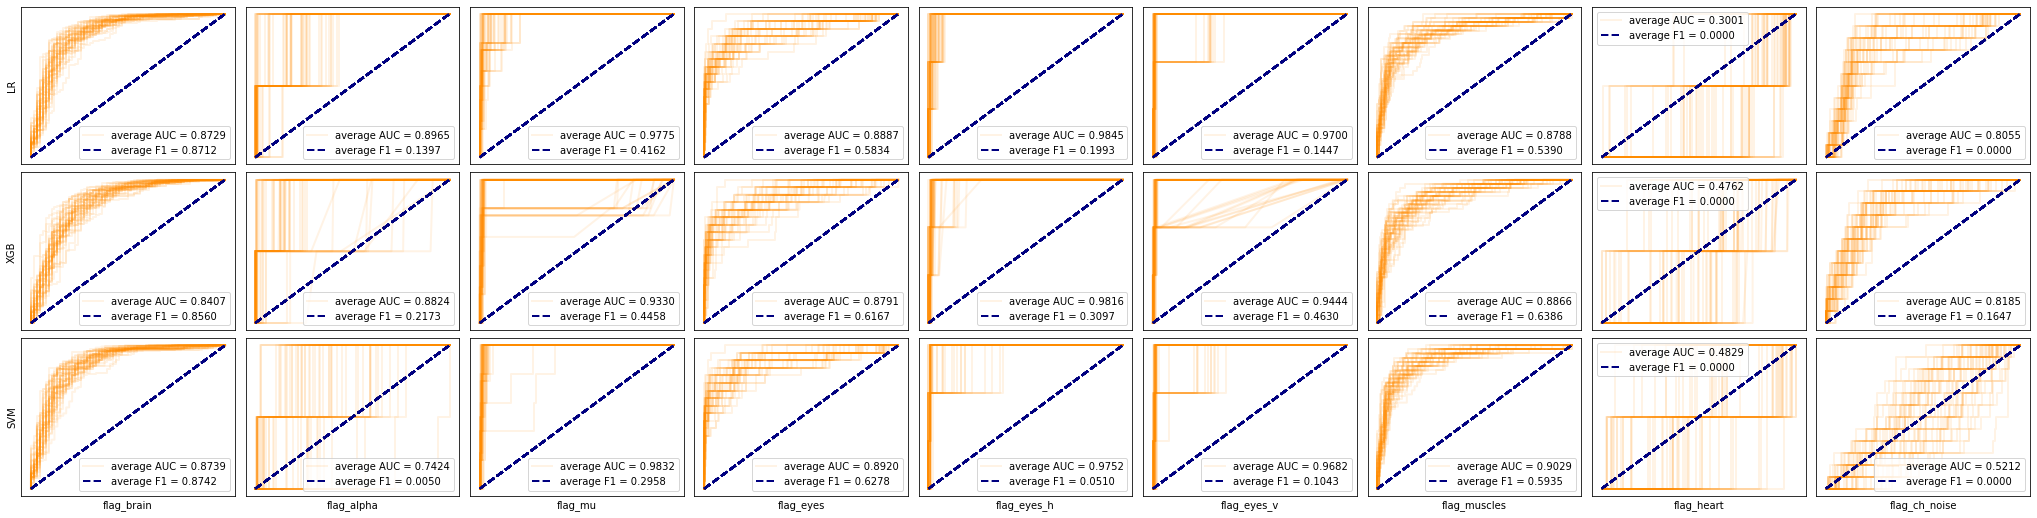

In [19]:
fig, axes = plt.subplots(len(models), len(targets.columns), figsize=(4 * len(targets.columns), 3 * len(models)))

for (model_name, model), row in zip(models.items(), axes):
    for flag, ax in zip(targets, row):
        _, _ = repeated_train_test(features, targets[flag], model, 50, ax=ax)
        ax.set_xlabel('')
    row[0].set_ylabel(model_name)
for target_name, ax in zip(targets, axes[-1]):
    ax.set_xlabel(target_name)

plt.subplots_adjust(wspace=0.05, hspace=0.05)

Хотя бы один эксперт.

In [26]:
targets = build_target_df(annotations, strategy='any')
targets = targets.loc[:, targets.any(axis=0)]

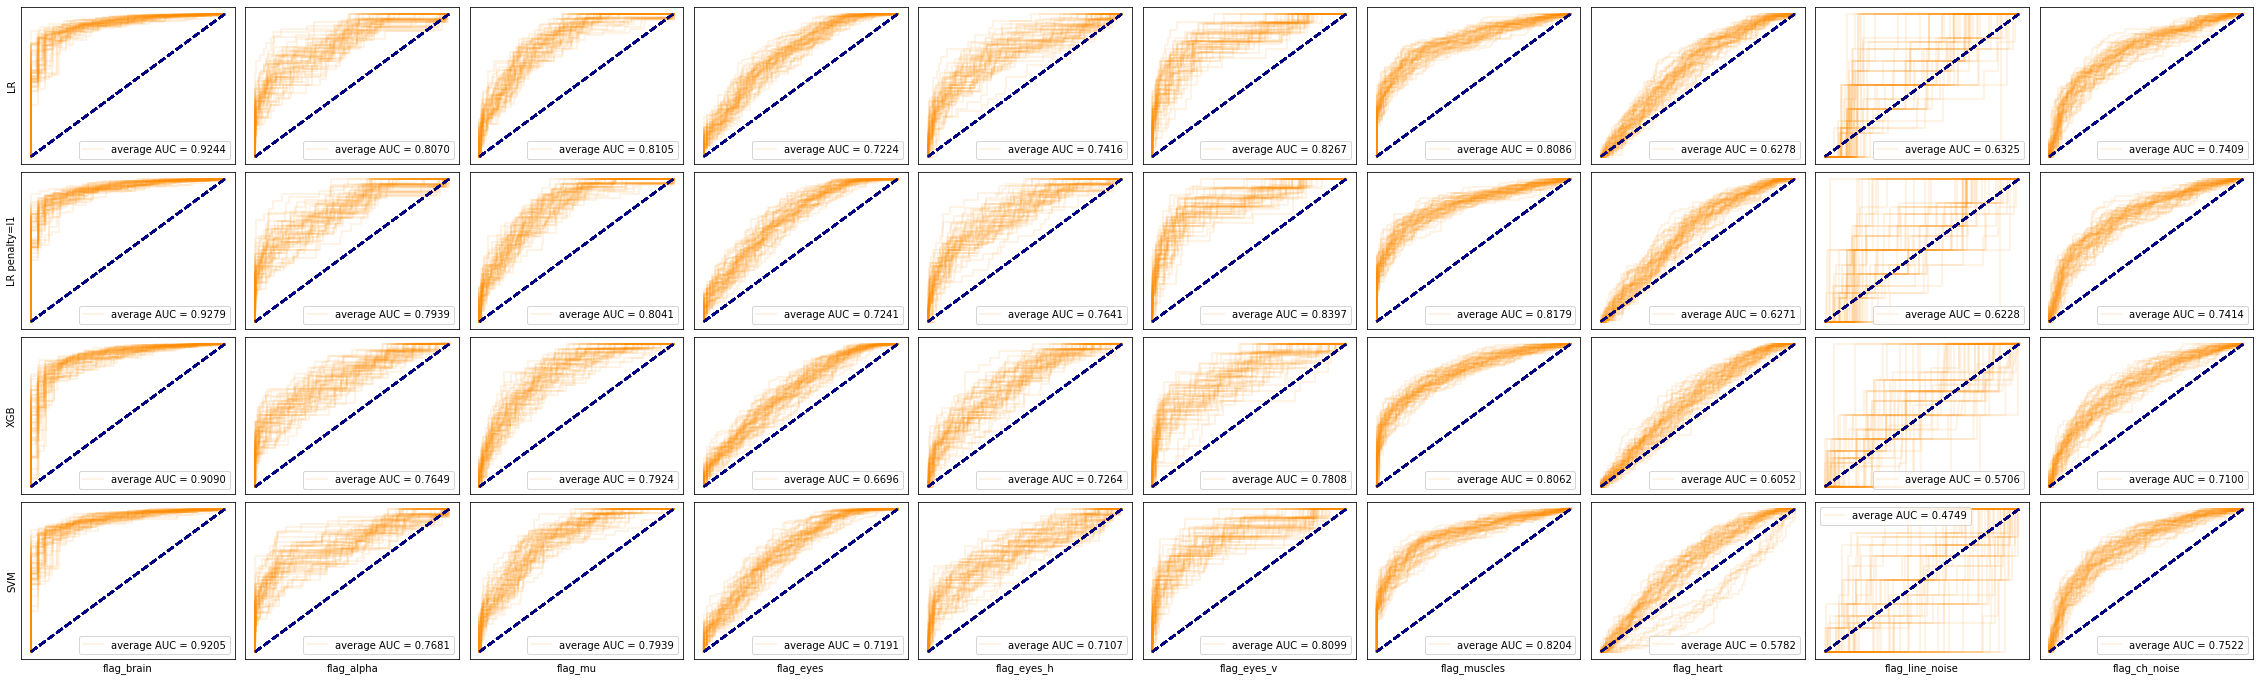

In [27]:
fig, axes = plt.subplots(len(models), len(targets.columns), figsize=(4 * len(targets.columns), 3 * len(models)))

for (model_name, model), row in zip(models.items(), axes):
    for flag, ax in zip(targets, row):
        _, _ = repeated_train_test(features, targets[flag], model, 50, ax=ax)
        ax.set_xlabel('')
    row[0].set_ylabel(model_name)
for target_name, ax in zip(targets, axes[-1]):
    ax.set_xlabel(target_name)

plt.subplots_adjust(wspace=0.05, hspace=0.05)

Голос эксперта равномерно делится между положительными метками.

In [28]:
targets = build_target_df(annotations, strategy='mean', weights='uniform', threshold=.3)
targets = targets.loc[:, targets.any(axis=0)]

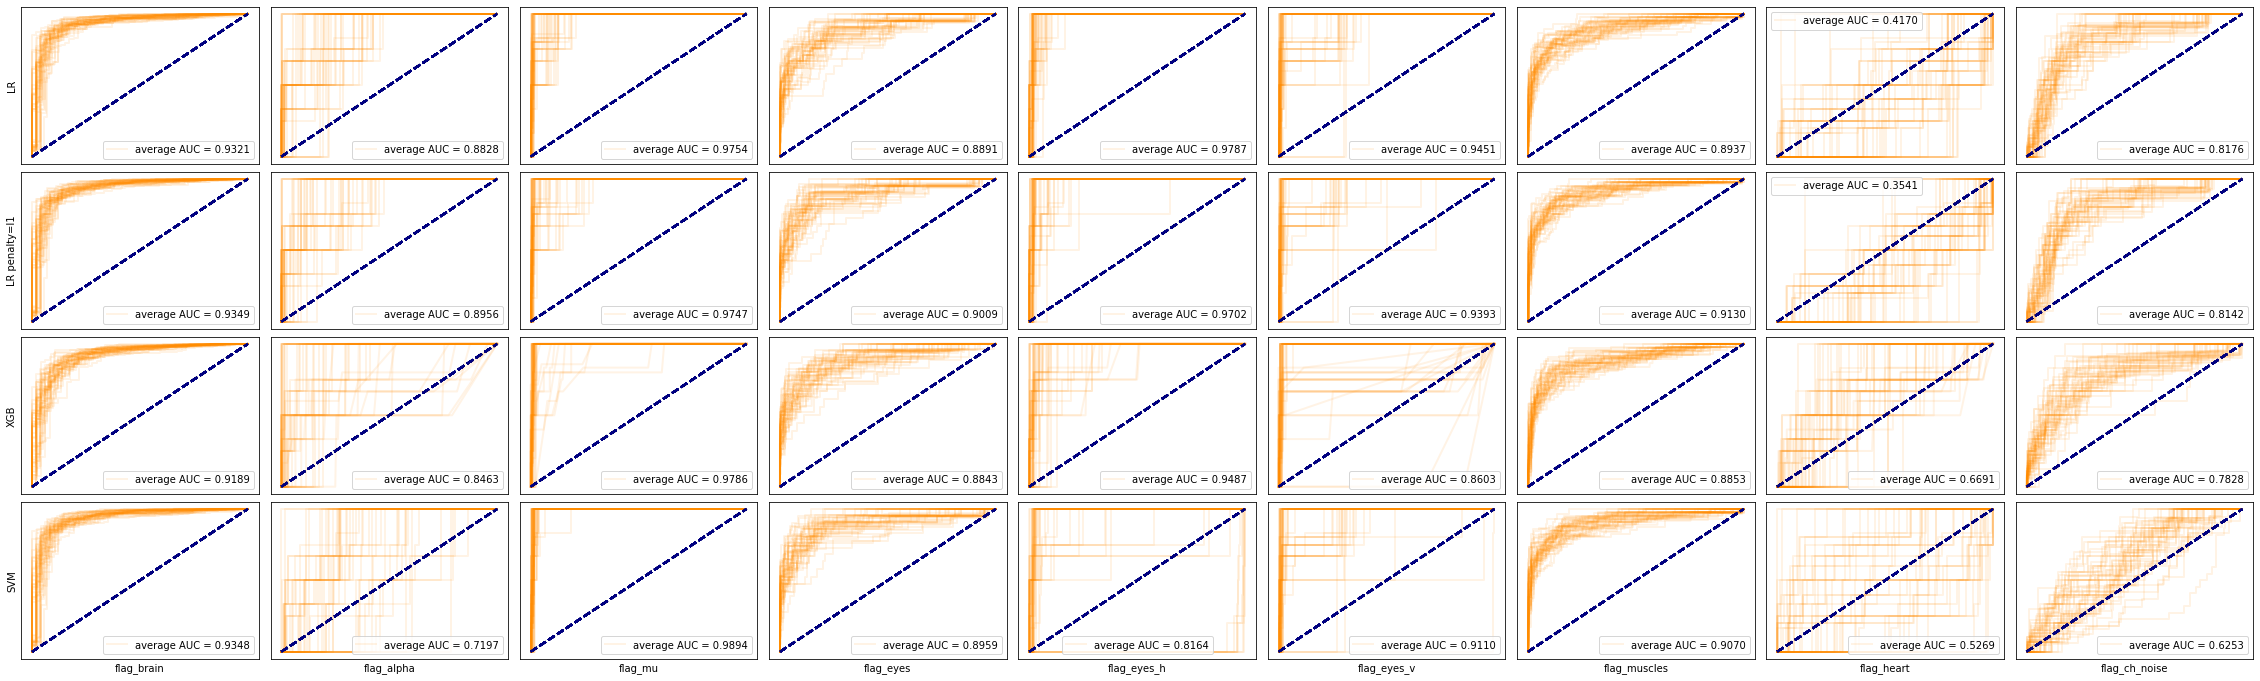

In [29]:
fig, axes = plt.subplots(len(models), len(targets.columns), figsize=(4 * len(targets.columns), 3 * len(models)))

for (model_name, model), row in zip(models.items(), axes):
    for flag, ax in zip(targets, row):
        _, _ = repeated_train_test(features, targets[flag], model, 50, ax=ax)
        ax.set_xlabel('')
    row[0].set_ylabel(model_name)
for target_name, ax in zip(targets, axes[-1]):
    ax.set_xlabel(target_name)

plt.subplots_adjust(wspace=0.05, hspace=0.05)